What to achieve:
Model improvements
- Custom loss function
- Add the VGG16 or Densenet50
- Add additional windows

Bug - seems to be fixed for now
 - May be able to fix using the dcm metadata:
 https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data
``` if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)```
     
 - May be because there is a class with less than 128
      - just 5 of each - validation and other
      - just 128 of each - validation and other
      - a train with only 128 and the same validation that we have now
      - Same train that we have now except stopping at a multiple of 128
 - May be in the validation data
      - a train with only 128 and the same validation that we have now
 - Try

Solution
    - One issue seems to be in validation
     - tried traingen w/ 128 and validgen with 128. Got an error regarding shape not being an attribute of DataGenerator_single_class
     - tried the same thing without validation data and didn't get any issue.
     - therefor at least one problem is with the validation data step

    - One option is to skip the validation step

    - Currently just running everything as normal except using test and valid data equal to multiples of batch_size

In [1]:
# Checking GPU availability
from __future__ import absolute_import, division, print_function, unicode_literals #to check for gpu

# %load_ext autoreload
# %autoreload 2

# Custom libraries
from custom_libraries import file_saving
from custom_libraries import image_processing
from custom_libraries import import_data
from custom_libraries import model_support

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Images
import pydicom
import cv2

# Batching for DataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence

# Keras, Tensorflow and other model related
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Checking devices and system settings
import sys
print("Python: ", sys.version[:6])
print("Keras: ",keras.__version__)
print("Tensorflow: ",tf.__version__)
print("GPU Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nAll devices:", *tf.config.experimental.list_physical_devices(),sep="\n")
gpu_count = len(tf.config.experimental.list_physical_devices('GPU'))

# saving to cloud storage
from google.cloud import storage
from custom_libraries import gcloud_storage


Using TensorFlow backend.


Python:  3.5.3 
Keras:  2.3.0
Tensorflow:  2.0.0
GPU Available:  True
Num GPUs Available:  1

All devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Set global variables
batch_size=128
dim=(512,512)
data_path = "../data/"   # used when calling DataGenerator
random_seed = 12345


## Import Data and Create Data Generator

In [3]:
# get df of image paths and labels
image_list = import_data.clean_data_csv(shuffle_data = True)

# remove images of different sizes (~200 images)
image_list = image_list[~image_list.filename.isin([x+'.dcm' for x in import_data.corrupted_images()])]

# create a df of images to use for analysis
data = import_data.balanced_images_binary(image_list)

# split train and validation data
train_data, valid_data = train_test_split(data, test_size = 0.15, random_state = random_seed)

In [4]:
# limit datasets to a multiple of batch_size
train_data_excess = len(train_data) % batch_size
valid_data_excess = len(valid_data) % batch_size

train_data = train_data[:-train_data_excess]
valid_data = valid_data[:-valid_data_excess]

In [5]:
traingen=image_processing.DataGenerator_single_class(train_data,data_path = data_path, batch_size = batch_size)
validgen=image_processing.DataGenerator_single_class(valid_data,data_path = data_path, batch_size = batch_size)

In [6]:
train_data_test = train_data[0:batch_size*5]
valid_data_test = valid_data[0:batch_size*1]

traingen_test=image_processing.DataGenerator_single_class(train_data_test,data_path = data_path, batch_size = batch_size)
validgen_test=image_processing.DataGenerator_single_class(valid_data_test,data_path = data_path, batch_size = batch_size)

In [7]:
train_data.info()
# valid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164864 entries, 77465 to 3511
Data columns (total 7 columns):
filename            164864 non-null object
any                 164864 non-null int64
epidural            164864 non-null int64
intraparenchymal    164864 non-null int64
intraventricular    164864 non-null int64
subarachnoid        164864 non-null int64
subdural            164864 non-null int64
dtypes: int64(6), object(1)
memory usage: 10.1+ MB


## Run Model

In [8]:
# option to load latest model
records = file_saving.load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]
loaded_model = file_saving.load_model(records_output = False, model_output = True, model_file_path = last_record)
model = loaded_model

In [9]:
# Add weighted log loss - https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model
model_notes = "model_2, with dropout, 165k images, balanced across any and none, binary, 512"
model_tags = ['binary', 'img_size:512']

epochs = 15
loss='binary_crossentropy'
optimizer='adam'

In [ ]:
# model_notes = "test, binary, 512"
# model_tags = ['binary', 'img_size:512', 'test']

In [ ]:
def model_1():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(dim[0], dim[1],1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5,5)))

    model.add(Flatten())  

    # model.add(Dense(100))
    # model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    # for 6 classes
    model.add(Dense(6, activation = 'sigmoid'))

    # for 1 class
    model.add(Dense(1, activation = 'sigmoid'))

    return model
model = model_1()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [12]:
def model_2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(dim[0], dim[1],1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5,5)))

    model.add(Flatten())  

    # model.add(Dense(100))
    # model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

#     # for 6 classes
#     model.add(Dense(6, activation = 'sigmoid'))

    # for 1 class
    model.add(Dense(1, activation = 'sigmoid'))

    return model
model = model_2()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# run model

history=model.fit_generator(
    generator=traingen,
    validation_data=validgen,
    use_multiprocessing=True,
    workers=11,
    epochs=epochs)

file_saving.save_model(
    model, 
    return_df=True, 
    model_notes=model_notes,
    loss = loss,
    optimizer = optimizer,
    dim = dim[0],
    epochs = epochs,
    train_size = len(train_data),
    validation_size = len(valid_data)
).tail(3)

Epoch 1/15


## Visualize Model Effectiveness

In [ ]:
y_pred = model.predict_generator(generator=validgen,use_multiprocessing=True)

In [ ]:
model_support.get_confusion_matrix(valid_data['any'],y_pred)

In [ ]:
# plot accuracy

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('models/latest_model_accuracy.png')
plt.show()


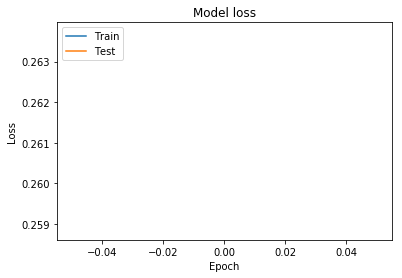

In [15]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('models/latest_model_loss.png')
plt.show()

## Loading Previous Models

In [18]:
# See df of most recent records
records = file_saving.load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]
records.tail(10)

,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
17,1,[],2019-10-19T020705_model.h5,test,models/2019-10-19T020705_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-19 02:07:05.253117,1,1
18,1,[],2019-10-19T071459_model.h5,"test, binary, 512",models/2019-10-19T071459_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-19 07:14:59.072233,1,1
19,1,[],2019-10-19T071537_model.h5,"test, binary, 512",models/2019-10-19T071537_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-19 07:15:37.685693,1,1
20,1,[],2019-10-19T074255_model.h5,"test, binary, 512",models/2019-10-19T074255_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-19 07:42:55.813587,1,1
21,1,[],2019-10-21T012256_model.h5,"test, binary, 512",models/2019-10-21T012256_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 01:22:56.730828,1,1
22,1,[],2019-10-21T012507_model.h5,"test, binary, 512",models/2019-10-21T012507_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 01:25:07.216196,1,1
23,1,[],2019-10-21T013017_model.h5,"test, binary, 512",models/2019-10-21T013017_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 01:30:17.505741,1,1
24,1,[],2019-10-21T013140_model.h5,"test, binary, 512",models/2019-10-21T013140_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 01:31:40.354051,1,1
25,1,[],2019-10-21T033555_model.h5,"165k train images, balanced across any and non...",models/2019-10-21T033555_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 03:35:55.310261,1,1
26,1,[],2019-10-21T051800_model.h5,"165k train images, balanced across any and non...",models/2019-10-21T051800_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 05:18:00.485887,1,1


In [19]:
# load_model last model
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = last_record)


In [29]:
y_pred = loaded_model.predict_generator(generator=validgen,use_multiprocessing=True)

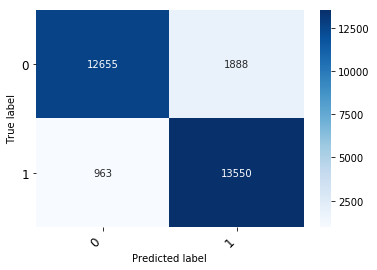

In [30]:
model_support.get_confusion_matrix(valid_data['any'],y_pred)

In [43]:
# load_model last model
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = last_record)
y_pred = loaded_model.predict_generator(generator=validgen,use_multiprocessing=True)

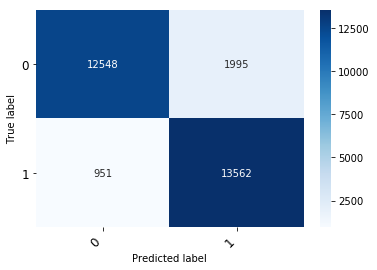

In [44]:
model_support.get_confusion_matrix(valid_data['any'],y_pred)

# TESTING

### Visualizing a batch of images

In [ ]:
# visualize a batch of images
batch = 27
batch_of_images = image_list[batch_size*np.min(batch-1,0):batch_size*batch]
image_paths = ['../data/stage_1_train_images/'+filename for filename in batch_of_images.filename]
image_processing.display_image_processing(image_paths = image_paths)

#### Saving and loading models

In [58]:
# barebones function to save. Used for testing the save functions

model_path = 'models/2019-10-13T224638_model.h5'
# keras.models.save_model(model, model_path)
loaded_model = tf.keras.models.load_model(model_path)


In [318]:
# test = save_model(model, model_tags = [],return_df=True, model_notes="hello")
# test

worked-1
worked-2


,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T211053_model.h5,NaN,models/2019-10-10T211053_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:53.796514,1,1
1,1,[],2019-10-10T211056_model.h5,NaN,models/2019-10-10T211056_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:56.404866,1,1
2,1,[],2019-10-10T211112_model.h5,hello,models/2019-10-10T211112_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:12.708478,1,1
3,1,[],2019-10-10T211115_model.h5,hello,models/2019-10-10T211115_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:15.211067,1,1
4,1,[],2019-10-10T211116_model.h5,hello,models/2019-10-10T211116_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:16.248314,1,1
5,1,[],2019-10-10T211129_model.h5,hello,models/2019-10-10T211129_model.h5,"{keras, tensorflow}",0,1,1,2019-10-10 21:11:29.360498,1,1


In [286]:
# root = 'models/'
# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df

,epochs,layers,model_name,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T202614_model.h5,models/2019-10-10T202614_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:14.109413,1,1
1,1,[],2019-10-10T202617_model.h5,models/2019-10-10T202617_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:17.506235,1,1
2,1,[],2019-10-10T202618_model.h5,models/2019-10-10T202618_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:18.759291,1,1
3,1,[],2019-10-10T202619_model.h5,models/2019-10-10T202619_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:19.641559,1,1
4,1,[],2019-10-10T202620_model.h5,models/2019-10-10T202620_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:20.819121,1,1
5,1,[],2019-10-10T202621_model.h5,models/2019-10-10T202621_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:21.808913,1,1
6,1,[],2019-10-10T202622_model.h5,models/2019-10-10T202622_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:22.799794,1,1
7,1,[],2019-10-10T202627_model.h5,models/2019-10-10T202627_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:27.330631,1,1


In [32]:
# Load model, if starting from a pre-made model
# root = 'models/'
# records_df, model = load_model(model_file_path="models/2019-10-11T004440_model.h5", model_output=True)

# from keras.initializers import glorot_uniform

# from keras.models import load_model
# from keras.utils import CustomObjectScope
# from keras.initializers import glorot_uniform
# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#         loaded_model = keras.models.load_model('models/2019-10-11T004440_model.h5')

# model = keras.models.load_model('models/2019-10-11T004440_model.h5',custom_objects={"GlorotUniform": keras.initializers.glorot_uniform})

# custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform}

# from keras.models import load_model
# from keras.utils import CustomObjectScope

# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

#         model = load_model('imdb_mlp_model.h5')

# root = 'models/'

# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df


#### Time

In [112]:
import time
# import datetime
from datetime import datetime

In [194]:
# d = date.today()
from datetime import datetime
d = datetime.utcnow()
d.isoformat()
d.strftime("%Y-%m-%dT%H%M%S")

'2019-10-10T195147'

In [55]:
# get df of image paths and labels
image_list_2 = import_data.clean_data_csv(shuffle_data = False)
image_paths_2 = ['../data/stage_1_train_images/'+filename for filename in image_list_2.filename]

In [57]:
len(image_paths_2[:10])

10

In [ ]:
corrupt_images = []
for image in image_paths_2[:10]:
    ds=pydicom.dcmread(img_path)
    raw=ds.pixel_array
    

    
# image_paths
image_processing.display_image_processing(image_paths = image_paths)
    

In [54]:
image_list_2[:10]

,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0.dcm,0,0,0,0,0,0
1,ID_00005679d.dcm,0,0,0,0,0,0
2,ID_00008ce3c.dcm,0,0,0,0,0,0
3,ID_0000950d7.dcm,0,0,0,0,0,0
4,ID_0000aee4b.dcm,0,0,0,0,0,0
5,ID_0000f1657.dcm,0,0,0,0,0,0
6,ID_000178e76.dcm,0,0,0,0,0,0
7,ID_00019828f.dcm,0,0,0,0,0,0
8,ID_0001dcc25.dcm,0,0,0,0,0,0
9,ID_0001de0e8.dcm,0,0,0,0,0,0
